In [1]:
from marss2l.utils import setup_stream_logger, get_remote_filesystem
fs = get_remote_filesystem()

Using account key


# CloudSEN12+ Experiment

We downloaded all cloud free images from the CloudSEN12+ dataset [available here](https://huggingface.co/datasets/tacofoundation/cloudsen12). For each of the 10,440 images we downloaded the corresponding 200x200 Sentinel-2 L1C image and the most similar cloud-free image from a time window of 8 months. We found a cloud free reference for all images except for 5. We compute the cloud masks of these images using the CloudSEN12 model and fetched the wind data from ERA5Land or NASA/GEOS/FP if the location is close to the coast line.

In [2]:
import pandas as pd
import os

with fs.open("az://public/MARS-S2L/dataset_20250609/cloudsen12_clear_images.csv", "r") as fh:
    dd = pd.read_csv(fh)

print(f"Number of images: {dd.shape[0]}")
print(f"Date of acquisition of the images: {dd.tile_date.min()} {dd.tile_date.max()}")
os.makedirs("figures", exist_ok=True)

Number of images: 10435
Date of acquisition of the images: 2017-05-30T10:30:21+00:00 2022-08-31T03:25:19+00:00


### Geographical distribution

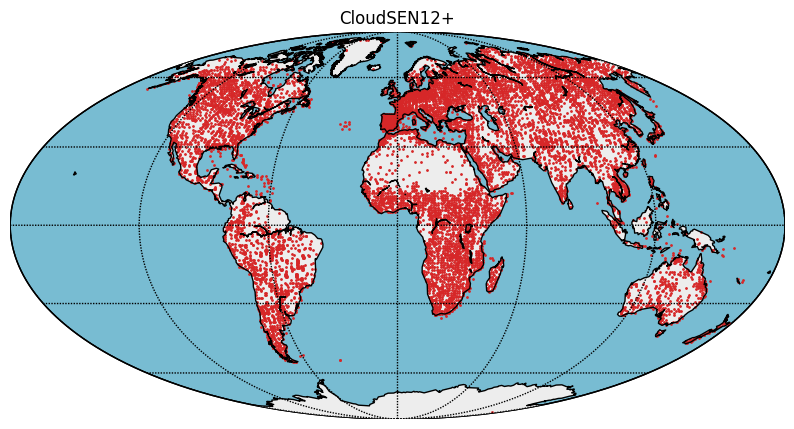

In [3]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1,1, figsize=(10,6))
ocean_color = (plt.get_cmap('ocean'))(210)
land_color = plt.get_cmap('gist_earth')(200)
land_color = "#ededed"
# lon_0 is central longitude of projection.
# resolution = 'c' means use crude resolution coastlines.
m = Basemap(projection='moll',lon_0=0,resolution='c',ax=ax)

m.drawcoastlines()
m.fillcontinents(color=land_color,lake_color=ocean_color)
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,120.,30.))
m.drawmeridians(np.arange(0.,420.,60.))
m.drawmapboundary(fill_color=ocean_color) 

x, y = m(dd.lon,dd.lat)
m.scatter(x,y,1,marker='o',color='C3')

ax.set_title("CloudSEN12+")

plt.savefig("figures/cloudsen12plus_locs.pdf")

**Fig X** Distribution of clear images used to estimate the global FPR

## Operational pipeline results

In the script to download all the clear CloudSEN12 images we also run the plume detection model with the operational MARS pipeline and the MARS-S2L model (called `'unetpaperrev_20250326v309'`). The following cell shows the results obtained:

In [4]:

fpr = dd.isplumepred.sum()/dd.shape[0] * 100
print(f"FPR: {fpr:.1f}% Total positive: {dd.isplumepred.sum()} Total: {dd.shape[0]}")

FPR: 2.4% Total positive: 250 Total: 10435


In [5]:
# Sanity check:
fpr2 = (dd.ch4_scene_probability > 0.5).sum()/dd.shape[0] * 100
fpr2

2.4053665548634404

**Caveat**: There are several samples with wind `NA` because they're near the coast and the interpolation of ERALand product gives `NaNs`.

In [6]:
(dd.wind_u.isna() | dd.wind_v.isna()).sum()

367

**Caveat 2**: some images are discarded in the operational pipeline because their cloud percentage is >= 50%. 

In [7]:
(dd.observability != "clear").sum()

91

## Results in `marss2l`

All data exported is available in the same format as the MARS-S2L dataset at `az://public/MARS-S2L/dataset_20250609/cloudsen12_clear_images.csv`. We can run the eval script in this data with the following commands. 

The next cell shows the results of these evals:

In [8]:
import pandas as pd
results_ch4net_csv = "az://public/MARS-S2L/train_logs_revision/CH4Net_20250329/preds_no splitcloudsen12th100.csv"
results_marss2l_csv = "az://public/MARS-S2L/train_logs_revision/MARSS2L_20250326/preds_no splitcloudsen12th100.csv"
results_mbmp_csv = "az://public/MARS-S2L/train_logs_revision/MBMP/preds_no splitcloudsen12th100.csv"

with fs.open(results_marss2l_csv, "r") as fh:
    d = pd.read_csv(fh)

d["isplumepred"] = d.scene_pred > 0.5
fpr = d.isplumepred.sum()/d.shape[0] * 100
print(f"MARS-S2L -> FPR: {fpr:.1f}% Total positive: {d.isplumepred.sum()} Total: {d.shape[0]}")

with fs.open(results_ch4net_csv, "r") as fh:
    dch4 = pd.read_csv(fh)

dch4["isplumepred"] = dch4.scene_pred > 0.5
fprch4 = dch4.isplumepred.sum()/dch4.shape[0] * 100
print(f"CH4Net -> FPR: {fprch4:.1f}% Total positive: {dch4.isplumepred.sum()} Total: {dch4.shape[0]}")

with fs.open(results_mbmp_csv, "r") as fh:
    dmbmp = pd.read_csv(fh)

threshold_mbmp = -.985
dmbmp["isplumepred"] = dmbmp.scene_pred > threshold_mbmp
fprch4 = dmbmp.isplumepred.sum()/dmbmp.shape[0] * 100
print(f"MBMP -> FPR: {fprch4:.1f}% Total positive: {dmbmp.isplumepred.sum()} Total: {dmbmp.shape[0]}")

MARS-S2L -> FPR: 9.4% Total positive: 984 Total: 10434
CH4Net -> FPR: 2.0% Total positive: 206 Total: 10434
MBMP -> FPR: 87.3% Total positive: 9108 Total: 10434


In [18]:
from marss2l.metrics import get_scenelevel_metrics, get_pixellevel_metrics
    
threshold_marss2l = 0.5
threshold_mbmp = -0.99
mets = []
for threshold_marss2l, threshold_mbmp in zip([0.5, 0.9, 0.98],[threshold_mbmp, -0.9, -0.85]):
    for model, dg in zip(["MBMP", "CH4Net", "MARS-S2L"],[dmbmp,dch4,d]):
        threshold = threshold_marss2l if not model.startswith("MBMP") else threshold_mbmp
        dg["isplumenum"] = 0
        mets_iter = get_scenelevel_metrics(dg.scene_pred, dg.isplumenum, threshold=threshold,
                                           as_percentage=True)
        mets_seg = get_pixellevel_metrics(TP=dg.TP, TN=dg.TN, FP=dg.FP, FN=dg.FN,
                                         as_percentage=True)
        mets_iter.update(mets_seg)
        mets_iter.update({"nsamples": dg.shape[0],
                     "nlocs": dg.location_name.nunique(),
                     "nplumes": 0,
                     "model_name": model,
                         "threshold": threshold})
        mets.append(mets_iter)

mets = pd.DataFrame(mets)# .sort_values(["balanced_accuracy"], ascending=False)
overall_mets = mets[["model_name"]+[c for c in mets.columns if c != "model_name"]].copy()
overall_mets[["model_name","threshold","fpr"]]

/home/gonzalo/mambaforge/envs/marss2ltacopy312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/gonzalo/mambaforge/envs/marss2ltacopy312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/gonzalo/mambaforge/envs/marss2ltacopy312/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:1033: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/gonzalo/git/marss2l/marss2l/metrics.py:76: RuntimeWarning: invalid value encountered in scalar divide
  recall = np.sum(TP) / np.sum(TP + FN)
/home/gonzalo/mambaforge/envs/marss2ltacopy312/lib/python3.12/site-package

,model_name,threshold,fpr
0,MBMP,-0.99,92.984474
1,CH4Net,0.50,1.974315
2,MARS-S2L,0.50,9.430707
3,MBMP,-0.90,27.649990
4,CH4Net,0.90,0.584627
5,MARS-S2L,0.90,1.811386
6,MBMP,-0.85,16.637915
7,CH4Net,0.98,0.239601
8,MARS-S2L,0.98,0.517539


In [19]:
print(overall_mets[["model_name","threshold","fpr"]].to_latex(index=False, float_format="%.2f"))

\begin{tabular}{lrr}
\toprule
model_name & threshold & fpr \\
\midrule
MBMP & -0.99 & 92.98 \\
CH4Net & 0.50 & 1.97 \\
MARS-S2L & 0.50 & 9.43 \\
MBMP & -0.90 & 27.65 \\
CH4Net & 0.90 & 0.58 \\
MARS-S2L & 0.90 & 1.81 \\
MBMP & -0.85 & 16.64 \\
CH4Net & 0.98 & 0.24 \\
MARS-S2L & 0.98 & 0.52 \\
\bottomrule
\end{tabular}

